In [2]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

In [3]:
# Loading the Navier-Stokes dataset in 128x128 resolution
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

# We create a tensorized FNO model

model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32

Our model has 393665 parameters.


In [8]:
for data in train_loader:
    print(data['x'].shape)
    break

torch.Size([32, 3, 16, 16])


In [18]:
for data in test_loaders[32]:
    print(data['x'].shape)
    break

torch.Size([32, 3, 32, 32])


In [5]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x7f10f1cbae30>

 * Test: {'h1': <neuralop.training.losses.H1Loss object at

In [6]:
# Create the trainer
trainer = Trainer(model, n_epochs=20,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)


# %%
# Actually train the model on our small Darcy-Flow dataset

trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on regular inputs (no multi-grid patching).
Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Training on raw inputs of size x.shape=torch.Size([32, 3, 16, 16]), y.shape=torch.Size([32, 1, 16, 16])
.. patched inputs of size x.shape=torch.Size([32, 3, 16, 16]), y.shape=torch.Size([32, 1, 16, 16])
Raw outputs of size out.shape=torch.Size([32, 1, 16, 16])
.. Processed (unpatched) outputs of size out.shape=torch.Size([32, 1, 16, 16])
[0] time=8.67, avg_loss=26.9340, train_err=0.5387, 16_h1=0.3928, 16_l2=0.3037, 32_h1=0.4784, 32_l2=0.3067
[3] time=8.49, avg_loss=11.2905, train_err=0.2258, 16_h1=0.2385, 16_l2=0.1838, 32_h1=0.3552, 32_l2=0.1763
[6] time=8.13, avg_loss=9.7222, train_err=0.1944, 16_h1=0.1934, 16_l2=0.1491, 32_h1=0.3582, 32_l2=0.1864
[9] time=7.80, avg_loss=8.2435, train_err=0.1649, 16_h1=0.1561, 16_l2=0.1094, 32_h1=0.3070, 32_l2=0.1504
[12] time=8.43, avg_loss=7.7328, train_err=0.1547, 16_h1=0.1765, 16_l2=0.1268, 32_h1=0.3149, 32_l2=

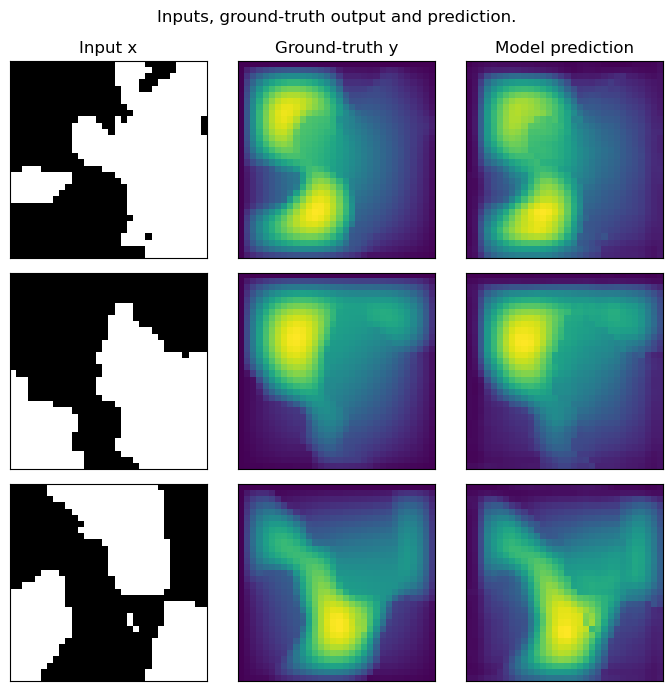

In [7]:
# Plot the prediction, and compare with the ground-truth 
# Note that we trained on a very small resolution for
# a very small number of epochs
# In practice, we would train at larger resolution, on many more samples.
# 
# However, for practicity, we created a minimal example that
# i) fits in just a few Mb of memory
# ii) can be trained quickly on CPU
#
# In practice we would train a Neural Operator on one or multiple GPUs

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()